In [29]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
plt.rcParams.update({'font.size': 22})

In [31]:
market_area = 'boston'
data_dir = 'index-team-data'
data_path = f'../{data_dir}/{market_area}'

In [32]:
listing_dates_df = pd.read_csv(f'{data_path}/listing_dates.csv')
listing_dates_df['zipcode'] = listing_dates_df['zipcode'].astype(str)

In [33]:
for event in 'list sale withdrawn expired cancelled'.split():
    column = event + '_date'
    listing_dates_df[column] = pd.to_datetime(listing_dates_df[column]).dt.date

In [34]:
print(listing_dates_df.shape)
listing_dates_df = listing_dates_df[
    (listing_dates_df['list_date'] < datetime.date.today()) &
    ((listing_dates_df['sale_date'] < datetime.date.today()) |
     (listing_dates_df['sale_date'].isna()))]
print(listing_dates_df.shape)

(452819, 12)
(452819, 12)


In [35]:
listing_dates_df.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,list_price,sale_price
0,175039535,1702,42.27250,-71.44128,2015-03-01,2015-04-27,NaT,NaT,NaT,Sale,349900.0,349900.0
1,504787545,2151,42.40187,-70.98765,2015-03-01,NaT,NaT,2015-10-01,NaT,Expired,599000.0,NaN
2,66951764,2445,42.33417,-71.13648,2015-03-07,2015-03-13,NaT,NaT,NaT,Sale,725000.0,745000.0
3,67506746,2536,41.55849,-70.58817,2015-03-09,2015-06-23,NaT,NaT,NaT,Sale,299000.0,299000.0
4,67096343,2052,42.20576,-71.32738,2015-03-11,2015-09-18,NaT,NaT,NaT,Sale,274900.0,274900.0


In [36]:
is_duplicated = listing_dates_df.duplicated('property_id', keep=False)
listing_dates_df_duplicated = listing_dates_df[is_duplicated]
listing_dates_df_duplicated = listing_dates_df_duplicated.sort_values('list_date')

In [37]:
listing_dates_df_duplicated_grouped = listing_dates_df_duplicated.groupby('property_id')

In [38]:
# For any house that went on the market multiple times within a 1-year period, 
# only count the first time the house was listed
days_cutoff = 365
cnt = 0
days_later_lst = []
rows_to_exclude = []
for _, df in listing_dates_df_duplicated_grouped:
    list_dates = list(df['list_date'])
    days_later = np.array([(list_dates[i + 1] - list_dates[i]).days for i in range(len(list_dates) - 1)])
    days_later_lst.extend(days_later)
    exclude_row = days_later < days_cutoff
    rows = df.index[1:]
    rows_to_exclude.extend(rows[exclude_row])

In [39]:
print(len(listing_dates_df))
listing_dates_df_cleaned = listing_dates_df.drop(rows_to_exclude, axis=0)
print(len(listing_dates_df_cleaned))

452819
439273


In [40]:
print('fraction of duplicate listings:', 
      (len(listing_dates_df) - len(listing_dates_df_cleaned)) / len(listing_dates_df))

fraction of duplicate listings: 0.029914822478738747


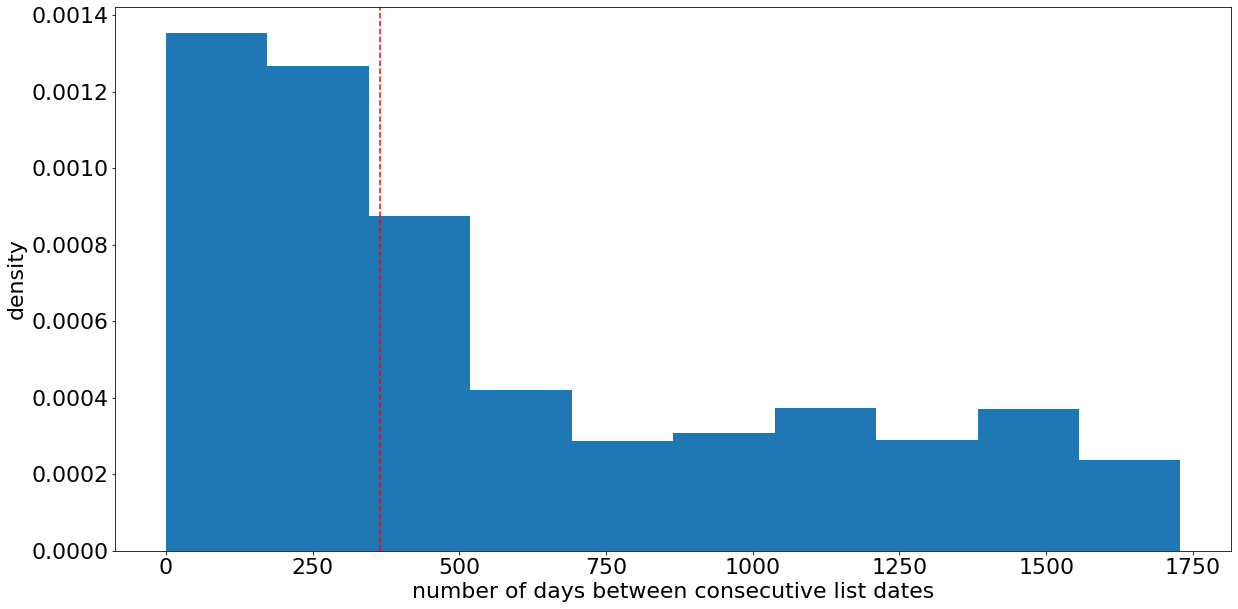

In [41]:
plt.figure(figsize=(20, 10))
plt.hist(days_later_lst, bins=10, density=True)
plt.xlabel('number of days between consecutive list dates')
plt.ylabel('density')
plt.axvline(x=days_cutoff, color='red', linestyle='--')
plt.show()

In [42]:
listing_dates_df_cleaned.to_csv(f'{data_path}/listing_dates_cleaned.csv', index=False)